In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
# import torchvision.models as models

### Loading Dataset

In [24]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match DenseNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Pre-trained model normalization

# Load datasets
train_dataset = datasets.ImageFolder(root='/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/Val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Covid', 'Normal']


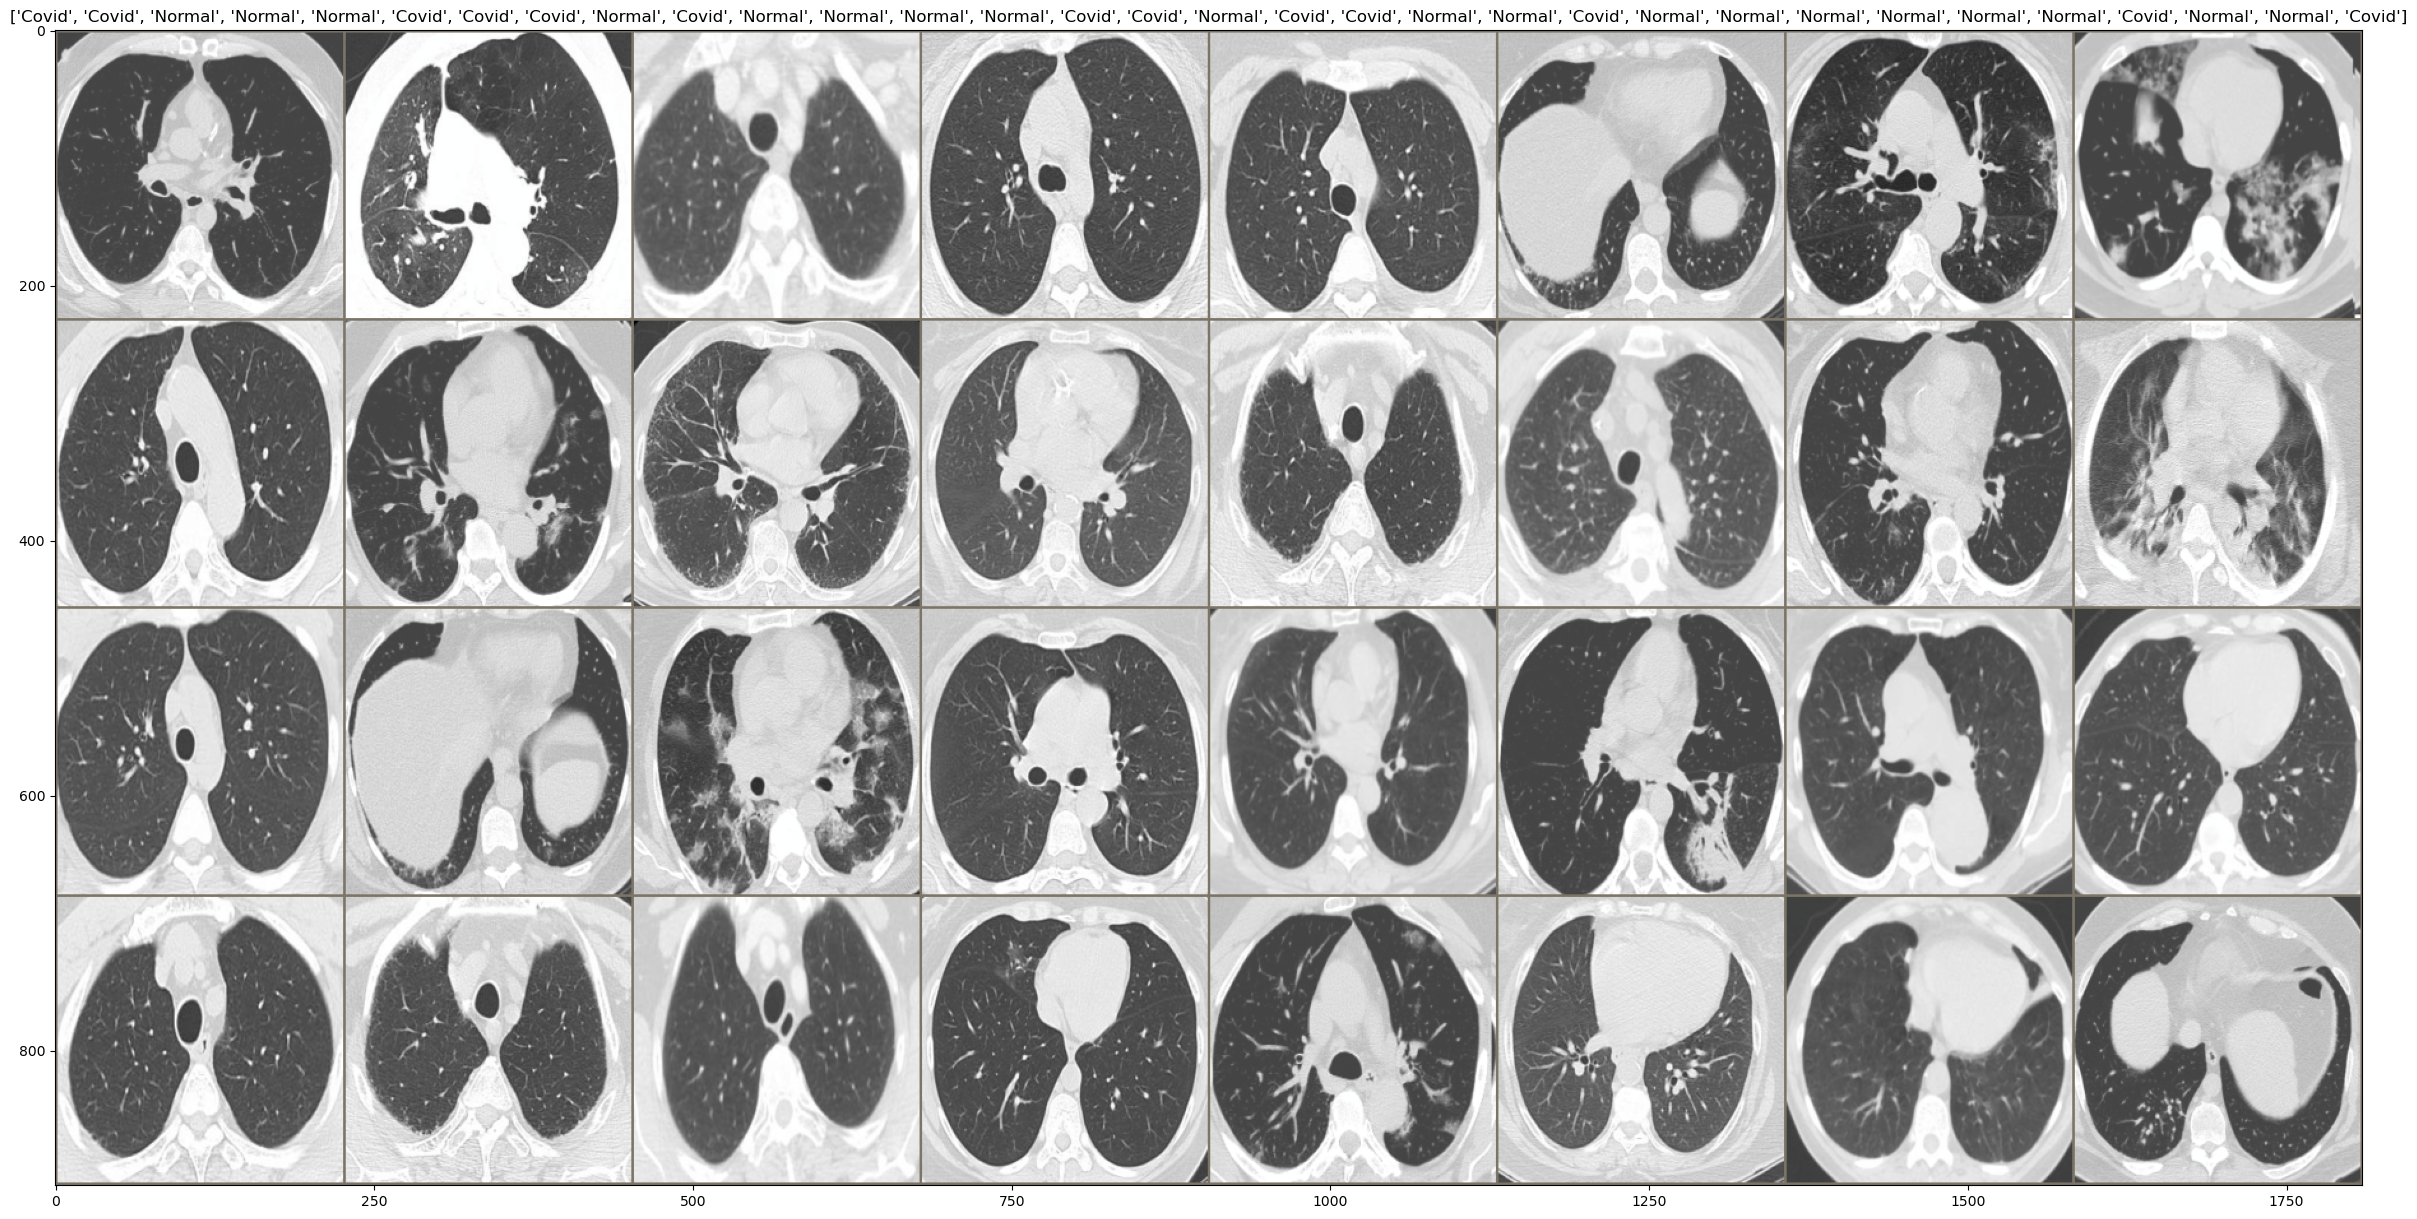

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(35,15))
# Function to show a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Denormalize
    inp = np.clip(inp, 0, 1)  # Clip to valid range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to allow update

# Load a batch of data from the train loader
inputs, labels = next(iter(train_loader))

# Display a grid of images with their labels
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[label] for label in labels])

### Loading Pre-Trained DenseNet

In [26]:
# Custom Model with Additional Convolutional Layers
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet, self).__init__()
        
        # Pre-trained DenseNet Model
        self.densenet = models.densenet121(pretrained=True)
        
        # Freeze DenseNet parameters (optional, for transfer learning)
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        # Additional Convolutional Layers
        self.extra_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Update the first layer of DenseNet to match new input dimensions
        self.densenet.features.conv0 = nn.Conv2d(256, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Classifier Layer
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        x = self.extra_layers(x)
        x = self.densenet(x)
        return x

# Instantiate and Test Model
num_classes = 2
model = CustomDenseNet(num_classes)

# Check the model architecture
# print(model)





# Load pre-trained DenseNet
# model = models.densenet121(pretrained=True)

# Modify the classifier to match the number of classes in your dataset
# num_features = model.classifier.in_features
# model.classifier = nn.Linear(num_features, len(class_names))

In [28]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Define Loss and Optimizer

In [30]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters())
# optimizer = torch.optim.NAdam(model.parameters())
# optimizer = torch.optim.Adamax(model.parameters())

### Model Training

In [32]:
# Training loop
num_epochs = 50
# num_epochs = 10
# num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/50, Loss: 0.655383664986183
Epoch 2/50, Loss: 0.4395828986990041
Epoch 3/50, Loss: 0.30738078879898995
Epoch 4/50, Loss: 0.2566731885589402
Epoch 5/50, Loss: 0.20846082475678673
Epoch 6/50, Loss: 0.24853954592655444
Epoch 7/50, Loss: 0.23641073986374098
Epoch 8/50, Loss: 0.1676555409513671
Epoch 9/50, Loss: 0.181250828607329
Epoch 10/50, Loss: 0.15368045095739694
Epoch 11/50, Loss: 0.1600612653740521
Epoch 12/50, Loss: 0.12925879002131266
Epoch 13/50, Loss: 0.15625536300498863
Epoch 14/50, Loss: 0.10325686466591112
Epoch 15/50, Loss: 0.11333974746280703
Epoch 16/50, Loss: 0.09326222872939603
Epoch 17/50, Loss: 0.09781895809132478
Epoch 18/50, Loss: 0.08416283406831067
Epoch 19/50, Loss: 0.06691652032193439
Epoch 20/50, Loss: 0.09148303233087063
Epoch 21/50, Loss: 0.0811009055067753
Epoch 22/50, Loss: 0.05759632080022631
Epoch 23/50, Loss: 0.05715354621924203
Epoch 24/50, Loss: 0.07884086870813165
Epoch 25/50, Loss: 0.13727879087472783
Epoch 26/50, Loss: 0.1492057156203122
Epoch

### Model Evaluation

In [36]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 49.14%


### Saving the Model

In [57]:
torch.save(model.state_dict(), "densenet_model.pth")
print("Model saved as densenet_model.pth")

Model saved as densenet_model.pth


### Load and Predict

In [96]:
# Load the saved model
model.load_state_dict(torch.load("densenet_model.pth"))
model.eval()

# Predict on a single image
from PIL import Image

img_path = "/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/single_prediction/covid.png"
# img = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
img = transform(img).unsqueeze(0)  # Apply transformations and add batch dimension

# Move to device and predict
img = img.to(device)
output = model(img)
_, predicted_class = torch.max(output, 1)
print(f"Predicted Class: {class_names[predicted_class.item()]}")

Predicted Class: Covid
